In [10]:
import pennylane as qml

from pennylane import numpy as np

import pennylane_lightning as plg
np.random.seed(42)

In [11]:
n_wires = 8
stepsize=0.5
graph = [(0, 1, 1), (0, 3, 1), (0,6,1), (1, 2,1), (2, 3,1), (2,7,1), (3,5,1),(1,5,1),(2,4,1),(4,5,1),(4,5,1),(5,6,1),(5,7,1),(6,7,1)]

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

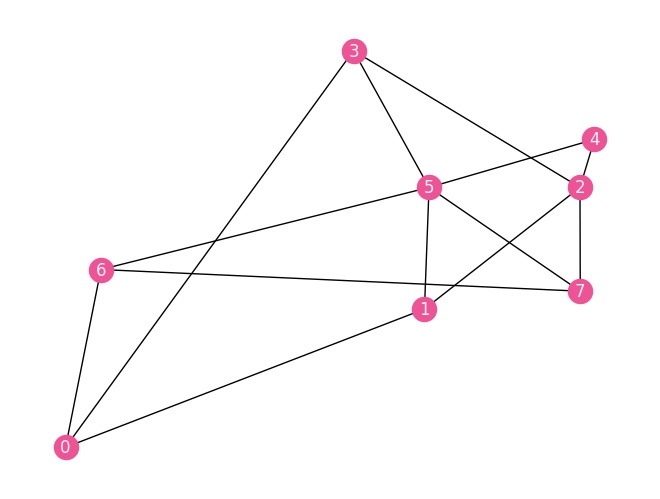

In [12]:
# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

G = rx.PyGraph()
G.add_nodes_from(range(n_wires))
G.add_edges_from(graph)
mpl_draw(
    G, pos=rx.random_layout(G, None, 4), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

In [13]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

In [14]:
#dev = qml.device("lightning.gpu", wires=n_wires, shots=100)
dev = qml.device("lightning.qubit", wires=n_wires, shots=100)
#dev = qml.device("qiskit.aer", wires=n_wires, shots=100)

In [15]:
@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

In [20]:
def qaoa_maxcut(n_layers=1, opt = qml.GradientDescentOptimizer(stepsize=stepsize)):
    print("\np={:d}".format(n_layers))
    
    # List to store loss values for the current method
    loss_values = []
    
    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)
    # init_params = np.random.rand(2, n_layers, requires_grad=True)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj


    # optimize parameters in objective
    params = init_params
    steps = 50
    for i in range(steps):
        params = opt.step(objective, params)
        loss = -objective(params)
        loss_values.append(loss)
        if (i + 1) % 10 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, loss))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:b}".format(most_freq_bit_string))
    
    plt.plot(loss_values, label=f"Adagrad Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Loss Function over Iterations - Adagrad")
    plt.legend()
    plt.show()

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=2)[1]


p=1
Objective after step    10:  7.5500000
Objective after step    20:  7.2900000
Objective after step    30:  7.8400000
Objective after step    40:  7.1200000
Objective after step    50:  7.0900000


ValueError: invalid literal for int() with base 2: '[0 0 1 1 0 0 1 1][1 0 1 0 1 1 1 1][1 0 0 0 0 1 1 0][0 0 0 0 1 1 0 0][0 0 0 0 1 1 0 0][1 0 0 0 1 0 1 0][1 0 1 0 0 1 0 1][1 0 1 0 1 0 0 0][0 1 1 1 0 0 0 0][0 0 1 0 1 1 1 0][1 1 1 1 1 1 1 1][1 0 1 0 0 0

In [16]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np_actual

def qaoa_maxcut(n_layers=1, method = "Nelder-Mead"):
    print("\np={:d}".format(n_layers))
    
    # List to store loss values for the current method
    loss_values = []
    
    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj


    # optimize parameters in objective
    params = init_params
    steps = 500
    
    def callback(x):
        # Compute the loss function value at each step
        loss_value = objective(x)
        loss_values.append(loss_value)
    
    try:
        res = minimize(objective, params, callback=callback)

        # Plot the loss values for this method
        plt.plot(loss_values, label=f"{method} Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"Loss Function over Iterations - {method}")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Optimization with method {method} failed: {e}")


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
qaoa_maxcut(n_layers=1)
qaoa_maxcut(n_layers=2)


p=1
Optimization with method Nelder-Mead failed: 'x0' must only have one dimension.

p=2
Optimization with method Nelder-Mead failed: 'x0' must only have one dimension.


In [ ]:
import matplotlib.pyplot as plt

m = 2**(n_wires)
xticks = range(0, m)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, (1 + m)) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 2, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.tight_layout()
plt.show()

In [ ]:
xticks = range(0, m)
xtick_labels = [format(x, f"0{n_wires}b") for x in xticks]  # Binary strings of fixed length `n_wires`
bins = np.arange(0, m + 1) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)

plt.subplot(1, 2, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)

plt.tight_layout()
plt.show()